4 Additive model, tree based regression and ensemble learning
-------------------
What happened so far is that you attempted to use a potentially complex model to fit our dummy data, but you also want to control the model to be not too complex. The main approach you took is to apply **regularization**. Briefly speaking, you tried to trim the model from a potentially complex one down to a simpler one. 

How about to try the other way around -- starting from an extremely simple model and add complexity to it until it meets our goal? This is exactly what **additive models** can do for you. You start with a very simply model, which only captures part of information in your dataset, or does not even apply to your entire dataset, but only a small fraction of it. Although each of these simple components may only capture the variable relationship within a small interval. But added together, several of these poor model components could be able to properly capture the pattern in the entire dataset. **Additive** is a general term describing such approach of combining simple model components no matter what kind of components you apply. **Decision Tree** is the most widely used **additive** model that combines simple binary classification nodes for larger scale **regression** tasks. For each of the nodes in a tree, it splits the dataset further into parts and apply simple analysis to capture the pattern within each splitted subset of the data. Such as taking the average of the subset as a simple regressed value. Essentially, **additive** models such as **decision tree** is a **classification** based **regression** model, it splits datasets according some classification criteria and takes the average values for every small interval of the entire dataset, and in combination, it acts like capturing the entire pattern of the whole dataset.

Following this logic of combining simple models, you can further combine several **decision trees** to form an **ensemble model** which aims at **ensemble learning**. In **ensemble learning**, each tree is applied to the data and trained in same manner. The results of all the trees would then be averaged to produce the final result. When trees are ensembled, they become *forest*, and thus the name **Random Forest** seems to be intuitively meaningful as a tree ensemble-based *machine learning* technique.

In this section, you will first learn to apply **Decision Tree** on, again, our dummy data set, to grab the idea of **tree based** regression. Then, you will be able to deploy the **ensemble** approach to apply **Random Forest** to larger dataset. ***You will be working with real dataset for the first time so far*** to experiment with all techniques you have learnt.

Again, before start, generate our dummy data. And also define functions to deploy regular linear 

In [12]:
%matplotlib inline  # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.

UsageError: unrecognized arguments: # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.


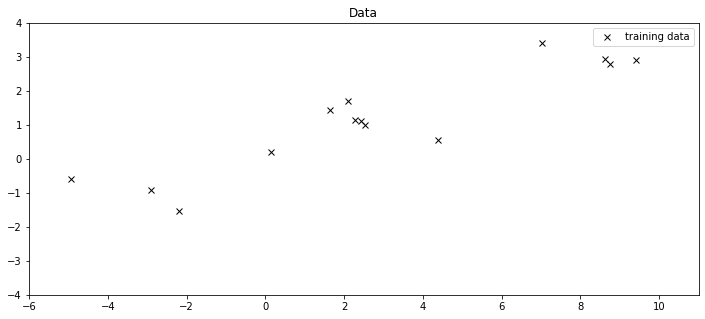

In [13]:
import numpy as np  # You will be using Numpy module
import matplotlib.pyplot as plt  # Module for visualization will also be used

# Define the true function for generating dummy dataset
def func(x):
    # Generate sample dataset from a linearly transformed sinusoidal function: y=sin(x)+0.3*x+e (where 'e' is random noise)
    return np.sin(x) + .3*x

# Define function for generating dummy dataset
def dummyData(func, sample_size, std):
    # Artificially generate input x
    x = np.random.rand(sample_size)[:,None]; x=x*15-5
    # Call function to generate response y
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

# A function to split your dataset into 'training' and 'validation' sets.
def trainValSplit(x, y):
    x_train = x[:int(0.7*len(x))]  # 70% of data for training
    x_val = x[int(0.7*len(x)):]  # 30% for testing
    y_train = y[:int(0.7*len(y))]  # 70% of data for training
    y_val = y[int(0.7*len(y)):]  # 30% for testing
    return x_train, y_train, x_val, y_val

# Prepare training and validation
x, y = dummyData(func, 20, 0.25)  # Generate 20 dummy data points by using function defined in section 0.0
x_train, y_train, x_val, y_val = trainValSplit(x, y)

x_all = np.linspace(-5, 10, 100).reshape(-1,1)

y_true = func(x_all)

# Visualize the artificially generated dataset
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data')
plt.plot(x_train,y_train,'kx',label='training data')
plt.legend()

### 4.0 Decision Tree and regression

In [14]:
# Source: https://austindavidbrown.github.io/post/2019/01/regression-decision-trees-in-python/

# First, let's compile the Decision Tree model
# You need Numpy and matplotlib again for computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# This time you define a class instead of a function for decision tree for regression
class RegTree():
    # You need a function to evaluate model performance as we did before
    @staticmethod
    def mse(v):
        return np.mean(np.square(v - np.mean(v)))

    # You also need a function to split/classify the dataset at each of the tree node
    @staticmethod
    def splitData(X, y, feature_index, feature_value):
        return {
            "I_left": np.where(X[:, feature_index] <= feature_value)[0],
            "I_right": np.where(X[:, feature_index] > feature_value)[0],
        }

    # You also need criteria to split/classify
    # Here, a algorithm calld Greedy algorithm is used for finding the best split
    @staticmethod
    def greedyBestSplit(X, y):
        best_feature_index = 0
        best_split_value = 0
        best_dloss = 0
        best_split = {
            "I_left": np.array([]),
            "I_right": np.array([]),
        }

        n_features = X.shape[1]
        parent_mse = RegTree.mse(y)
        N = y.shape[0]
        for feature_index in range(0, n_features):
            split_values = np.unique(X[:, feature_index])
            for split_value in split_values:
                split = RegTree.splitData(X, y, feature_index, split_value)
                
                # If there is a split
                if split["I_left"].shape[0] > 0 and split["I_right"].shape[0] > 0:
                    # Compute the change in loss
                    N_left = split["I_left"].shape[0]
                    N_right = split["I_right"].shape[0]
                    dloss = parent_mse - 1/N * (N_left * RegTree.mse(y[split["I_left"]]) + N_right * RegTree.mse(y[split["I_right"]]))

                    # Update if the change in loss is the largest so far
                    if dloss >= best_dloss:
                        best_feature_index = feature_index
                        best_split_value = split_value
                        best_split = split
                        best_dloss = dloss

        return best_dloss, best_feature_index, best_split_value, best_split

    @staticmethod
    def fitTree(X, y, depth = 1, max_depth = 100, tolerance = 10**(-3)):
        node = {}

        # Predict with the mean
        node["w"] = np.mean(y)

        node["left"] = None
        node["right"] = None

        # If we can split, find the best split by greedy algorithm
        if y.shape[0] >= 2:
            dloss, feature_index, split_value, split = RegTree.greedyBestSplit(X, y)
            # If there is a greedy split and the stopping criterion is not met, branch 2 times
            if split["I_left"].shape[0] > 0 and split["I_right"].shape[0] > 0 and dloss >= tolerance and depth < max_depth:
                node["dloss"] = dloss
                node["feature_index"] = feature_index
                node["split_value"] = split_value

                node["left"] = RegTree.fitTree(X[split["I_left"]], y[split["I_left"]], depth = depth + 1, max_depth = max_depth, tolerance = tolerance)
                node["right"] = RegTree.fitTree(X[split["I_right"]], y[split["I_right"]], depth = depth + 1, max_depth = max_depth, tolerance = tolerance) 
        return node

    ###
    # Predict
    ###
    @staticmethod
    def predictOne(node, x):
        if node["left"] == None:
            return node["w"]
        else:
            if x[node["feature_index"]] <= node["split_value"]:
                return RegTree.predictOne(node["left"], x)
            else:
                return RegTree.predictOne(node["right"], x)

    @staticmethod
    def predict(node, X):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        for i in range(0, n_samples):
            predictions[i] = RegTree.predictOne(node, X[i])
        return predictions

    @staticmethod
    def printTree(node, depth = 0):
        if node["left"] == None:
            print(f'{depth * "  "}weight: {node["w"]}')
        else:
            print(f'{depth * "  "}X{node["feature_index"]} <= {node["split_value"]}')
            RegTree.printTree(node["left"], depth + 1)
            RegTree.printTree(node["right"], depth + 1)

In [15]:
# Again, we used dummy dataset created in section 2.0 as it contains both training and test sets.

# The most important parameter is the depth of the tree.
# Try to experiment with this parameter.
model_tree = RegTree.fitTree(x_train, y_train, max_depth = 3, tolerance = 10**(-2))

print("Train MSE:", 1/x_train.shape[0] * np.sum(np.square(y_train - RegTree.predict(model_tree, x_train))))

Train MSE: 58.778843106702034


In [16]:
# How does the model perform on validation set?
print("Train MSE:", 1/x_val.shape[0] * np.sum(np.square(y_val - RegTree.predict(model_tree, x_val))))

Train MSE: 23.83545666088849


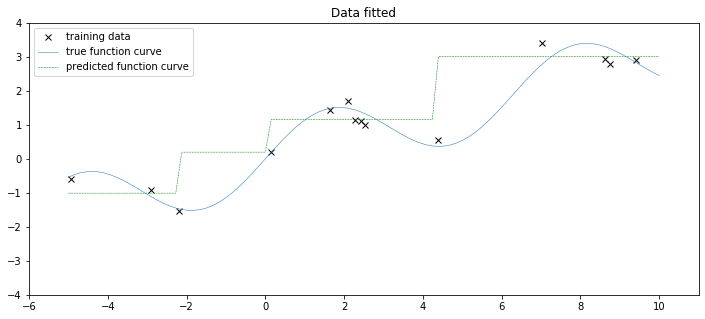

In [17]:
# Try to predict everywhere to see the predicted function curve
y_predict = RegTree.predict(model_tree, x_all)

# Plot the data. How does it look like compared to the curves you already fitted in all previous sections?
# Similarly, try to experiment with different parameters in configuring your Decision Tree.
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data fitted')
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_all, y_true, linewidth=.5, label='true function curve')
plt.plot(x_all, y_predict, '--g', linewidth=.5, label='predicted function curve')
plt.legend()

### 4.1 Decision Tree in sklearn

Similar to what you already encountered in **lasso regression**, you don't have to always write your own functions from scratch for the **Decision Tree** based regression. You can again use the ***sklearn*** module, which is a powerful package contains several machine learning based algorithms, including variations of **tree** based regression, such as the **Decision Tree** and its **additive** versions.

In [18]:
# Import sklearn along with all necessary modules

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

# Initiate a tree model
tree_depth = 3
model_tree = DecisionTreeRegressor(max_depth=tree_depth)

# Fit the model to your data.
# Please note that the output of this fitting is a model with several parameters that are configurable, so far you only configured "max_depth" while training/fitting.
model_tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

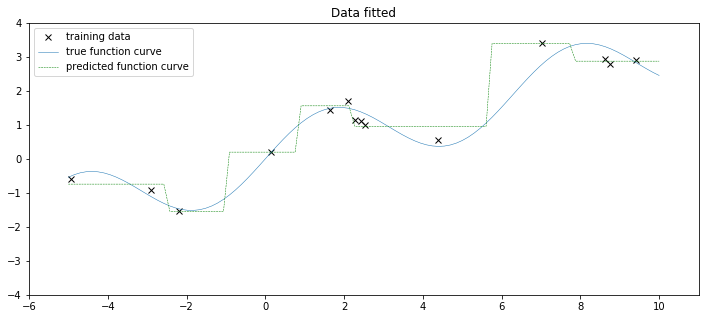

In [19]:
# Use the fitted model to predict every where for visualizing the fitted curve
y_predict = model_tree.predict(x_all)

# Plot
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data fitted')
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_all, y_true, linewidth=.5, label='true function curve')
plt.plot(x_all, y_predict, '--g', linewidth=.5, label='predicted function curve')
plt.legend()

### 4.2 Further inspection: features and feature selection

As been said, the **decision tree** model is basically a classification based model, and the **regression** has been achieved in each splitted/classified interval by simply taking the average of the data within the interval. Then, apart from the **tree depth**, another important criteria is the choice of best split point at each tree node.

Given the input training data, the following codes shows you how the dataset has been splitted at each node by using the data points in the dataset as the splitting value.

[Text(306.90000000000003, 428.08500000000004, 'X[0] <= 0.896\nentropy = 2.15\nsamples = 14\nvalue = 1.155'),
 Text(167.4, 305.775, 'X[0] <= -1.027\nentropy = 0.393\nsamples = 4\nvalue = -0.707'),
 Text(111.60000000000001, 183.46500000000003, 'X[0] <= -2.551\nentropy = 0.159\nsamples = 3\nvalue = -1.009'),
 Text(55.800000000000004, 61.15499999999997, 'entropy = 0.026\nsamples = 2\nvalue = -0.743'),
 Text(167.4, 61.15499999999997, 'entropy = 0.0\nsamples = 1\nvalue = -1.541'),
 Text(223.20000000000002, 183.46500000000003, 'entropy = -0.0\nsamples = 1\nvalue = 0.199'),
 Text(446.40000000000003, 305.775, 'X[0] <= 5.708\nentropy = 0.913\nsamples = 10\nvalue = 1.899'),
 Text(334.8, 183.46500000000003, 'X[0] <= 2.198\nentropy = 0.123\nsamples = 6\nvalue = 1.161'),
 Text(279.0, 61.15499999999997, 'entropy = 0.019\nsamples = 2\nvalue = 1.562'),
 Text(390.6, 61.15499999999997, 'entropy = 0.054\nsamples = 4\nvalue = 0.96'),
 Text(558.0, 183.46500000000003, 'X[0] <= 7.823\nentropy = 0.054\nsamples

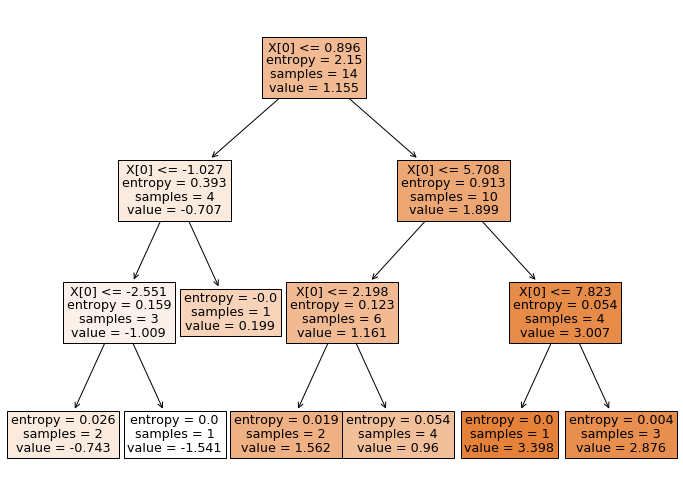

In [20]:
from sklearn import tree

# Try to interpret what is going on along the tree nodes.
# Hint: since there is only 1 dimension in the dataset, it means the dataset has always been splitted on the first dimension.
# X[0] means the first dimension of the dataset.
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))  # Adjust figure size according to the tree shape
tree.plot_tree(model_tree, filled=True)

### Short exercise 4.0

The above example applied the **decision tree** to the original dummy dataset with 1 **dimension**. What if you have a dataset with higher **dimensions**? Actually, you should be familiar with this situation. In the example of polynomial model fitting, we have already projected our input **X** into higher dimensions by using the polynomial transformation!

It's all about perspective. Polynomial regression is essentially a linear regression in high dimensions, where each dimension in *(x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>,..., x<sub>n</sub>)* are also called polynomial **features** of the input *x* in the form of *(x<sup>1</sup>, x<sup>2</sup>, x<sup>3</sup>,..., x<sup>n</sup>)*. At this moment, it is also important to stress that **dimensions**, **features**, and **variables** are commonly used interchangably in many data science study cases. For instance, as we mentioned in *section 1.1*, polynomial regression is also a multi **variable** regression that each polynomial term can be treated as a input variable.

So, try to experiment with your tree configuration to inspect how the parameters of a tree impact the regression results. And how the data points are used to split the dataset at each node of your tree model. In the following section, you will see a **decision tree** model be trained with 2-dimensional input data **X**. Try to understand the following code and modify the input data dimensionality, and interpret the visualization.

[Text(283.2923076923077, 428.08500000000004, 'X[0] <= 0.896\nentropy = 2.15\nsamples = 14\nvalue = 1.155'),
 Text(103.01538461538462, 305.775, 'X[1] <= 2.431\nentropy = 0.393\nsamples = 4\nvalue = -0.707'),
 Text(51.50769230769231, 183.46500000000003, 'entropy = 0.0\nsamples = 1\nvalue = 0.199'),
 Text(154.52307692307693, 183.46500000000003, 'X[1] <= 6.631\nentropy = 0.159\nsamples = 3\nvalue = -1.009'),
 Text(103.01538461538462, 61.15499999999997, 'entropy = 0.0\nsamples = 1\nvalue = -1.541'),
 Text(206.03076923076924, 61.15499999999997, 'entropy = 0.026\nsamples = 2\nvalue = -0.743'),
 Text(463.5692307692308, 305.775, 'X[0] <= 5.708\nentropy = 0.913\nsamples = 10\nvalue = 1.899'),
 Text(360.55384615384617, 183.46500000000003, 'X[1] <= 4.839\nentropy = 0.123\nsamples = 6\nvalue = 1.161'),
 Text(309.04615384615386, 61.15499999999997, 'entropy = 0.019\nsamples = 2\nvalue = 1.562'),
 Text(412.0615384615385, 61.15499999999997, 'entropy = 0.054\nsamples = 4\nvalue = 0.96'),
 Text(566.58461

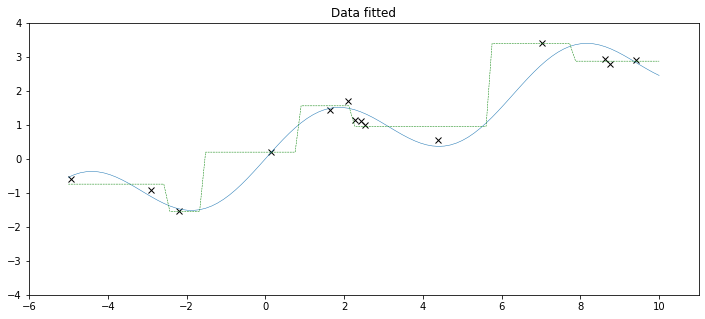

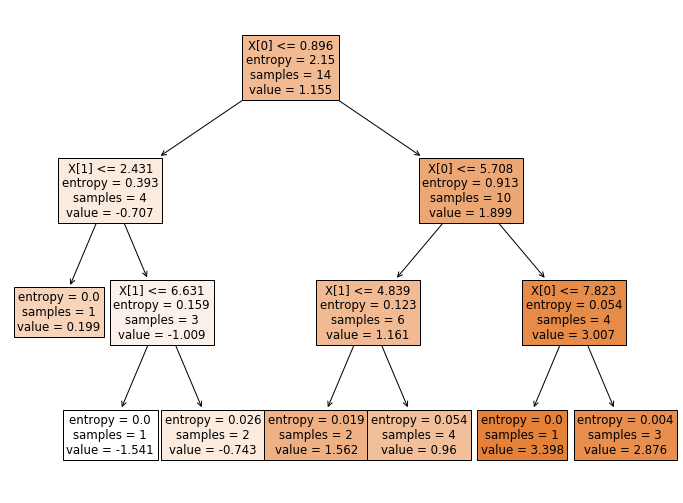

In [22]:
import functools
import itertools

# Define a fuction that project inputs into higher order polynomial inputs. 
# For instance, when degree=3, x becomes to (x, x^2, x^3).
def transform(x, degree):
    # Transforms input array with polynomial features
    # x : (sample_size, n) ndarray
    # Output : (sample_size, 1 + nC1 + ... + nCd) ndarray

    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = []
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()

# Initiate a tree model
tree_depth = 3
model_tree = DecisionTreeRegressor(max_depth=tree_depth)

# First transform inputs with higher order features based upon the degree
deg = 2  # Again, similar as in section 1.1, 8 degree is used.
# Fit the model to your data.
x_poly = transform(x_train,deg)
model_tree.fit(x_poly, y_train)

# Use the fitted model to predict every where for visualizing the fitted curve
y_predict = model_tree.predict(transform(x_all,deg))

# Plot
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data fitted')
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_all, y_true, linewidth=.5)
plt.plot(x_all, y_predict, '--g', linewidth=.5)

# Tree visualization
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))  # Adjust figure size according to the tree shape
tree.plot_tree(model_tree, filled=True)

Along the tree model, you have already seen that some data value on certain dimension is best for splitting data. It means that certain data point of a dimension or feature can be used best for capture data variance. It then indicate some data dimension or input feature are more important than the others for our regression analysis.

In **decision tree** model, it allows you to rank the feature importance for your tree-based regression.

Feature: 0, Score: 0.93278
Feature: 1, Score: 0.06722


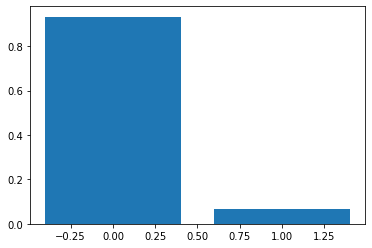

In [23]:
# Get feature importance
importance = model_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Plot feature importance
plt.bar([ind for ind in range(len(importance))], importance)
plt.show()

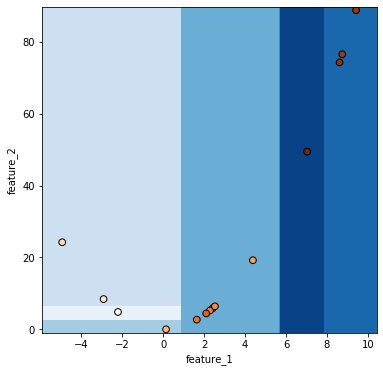

In [24]:
# The tree-based model can also be visualized in a different way to see how data has been splitted.
# Let's plot how the features split the data

# Plot parameters
plot_colors = "ryb"
plot_step = 0.02

# Plot the decision boundary
plt.figure(figsize=(6, 6))

x_min, x_max = x_poly[:, 0].min() - 1, x_poly[:, 0].max() + 1
y_min, y_max = x_poly[:, 1].min() - 1, x_poly[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = model_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

plt.xlabel('feature_1')
plt.ylabel('feature_2')

plt.scatter(x_poly[:, 0], x_poly[:, 1], c=y_train.reshape(y_train.shape[0]), cmap='Oranges', edgecolor='black', s=45)

### 4.3 Ensemble trees: Random Forest


The **ensemble** approach is very straight forward. The **ensemble** of tree models simply combines and averages the result of all the trees contained in the **ensemble**.

Please try to experiment with the following codes to have an idea about how one of the most famous **ensemble** models, the **Random Forest**, works on our dummy dataset.

Please also refer to the *sklearn* online documentation to further explore the potential of the **Random Forest**.

C:\Users\Jon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Feature: 0, Score: 0.40558
Feature: 1, Score: 0.05351
Feature: 2, Score: 0.15875
Feature: 3, Score: 0.02294
Feature: 4, Score: 0.23289
Feature: 5, Score: 0.02932
Feature: 6, Score: 0.06426
Feature: 7, Score: 0.03274


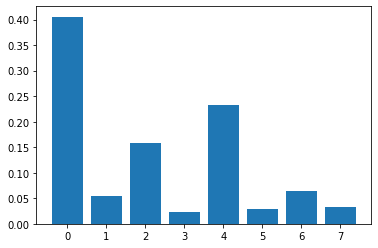

In [25]:
# Below is a short example showing the Random Forest for feature importance on a regression problem

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

deg = 8  # Again, similar as in section 1.1, 8 degree is used.
# Fit the model to your data.
x_poly = transform(x_train,deg)

# Define the Random Forest model
model_rf = RandomForestRegressor()
# Fit the model
model_rf.fit(x_poly, y_train)
# get importance
importance = model_rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([ind for ind in range(len(importance))], importance)
plt.show()